In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
# sys.path.append('/home/niklas/projects/style_transfer')
from oads_access.oads_access import OADS_Access, OADSImageDataset
from pytorch_utils.pytorch_utils import collate_fn, ToOpponentChannel
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

from oads_access.oads_style_transfer import run_style_transfer, image_loader, imshow_tensor, UnNormalize
import copy

/home/niklas/anaconda3/envs/oads/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

basedir = '/home/niklas/projects/data/oads/'
oads = OADS_Access(basedir=basedir)

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

# Dataset

In [4]:
identifier = {  'resnet50': {'coc': {'raw': '2023-03-23-17:33:53', 'jpeg': 'jpeg/2023-03-23-17:46:03'}, 
                            'rgb': {'raw': '2023-03-24-17:09:46', 'jpeg': 'jpeg/2023-03-23-17:25:59'}},
                'resnet18': {'coc': {'raw': '2023-03-23-17:13:29', 'jpeg': 'jpeg/2023-03-23-17:11:42'}, 
                            'rgb': {'raw': '2023-03-23-13:55:28', 'jpeg': 'jpeg/2023-03-23-14:04:46'}},
            }

In [5]:
import os
from torchvision.models import resnet50, resnet18

n_input_channels = 3
output_channels = 19

models = {}

for model_type in ['resnet18', 'resnet50']:
    models[model_type] = {}
    for image_representation in ['rgb', 'coc']:
        models[model_type][image_representation] = {}
        for image_quality in ['raw', 'jpeg', 'random']:


            if model_type == 'resnet50':
                model = resnet50()
                model.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=model.conv1.out_channels, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
                model.fc = nn.Linear(
                    in_features=2048, out_features=output_channels, bias=True)
            elif model_type == 'resnet18':
                model = resnet18()
                model.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=model.conv1.out_channels, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
                model.fc = nn.Linear(
                    in_features=512, out_features=output_channels, bias=True)

            model = nn.DataParallel(model)

            if 'random' not in image_quality:
                model_path = f'/home/niklas/projects/oads_results_snellius/normalized/oads_results/{model_type}/{image_representation}/{identifier[model_type][image_representation][image_quality]}'
                model_path = os.path.join(model_path, [x for x in os.listdir(model_path) if 'best_model' in x][0])
                model.load_state_dict(torch.load(model_path))

            model = model.to(device=device)

            model.eval()

            models[model_type][image_representation][image_quality] = model

criterion = nn.CrossEntropyLoss()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# desired size of the output image
imsize = 400 if torch.cuda.is_available() else 128  # use small size if no gpu

mean = [0.3410, 0.3123, 0.2787]
std = [0.2362, 0.2252, 0.2162]

transform = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])


oads_transform = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])  # transform it into a torch tensor
    
    # transform_list = []
    # transform_list.append(transforms.Resize(imsize, imsize))

    # # Apply color opponnent channel representation
    # if 'coc' in image_representation:
    #     transform_list.append(ToOpponentChannel())

    # transform_list.append(transforms.ToTensor())
    # transform_list.append(transforms.Normalize(mean, std))

    # oads_transform[image_representation] = transforms.Compose(transform_list)

In [ ]:
class_index_mapping = {}
index_label_mapping = {}
for index, (key, item) in enumerate(list(oads.get_class_mapping().items())):
    class_index_mapping[key] = index
    index_label_mapping[index] = item

In [ ]:
classes = ['Bollard', 'Van', 'Front door', 'Oma fiets', 'Truck', 'Bench', 'Lamppost', 'Tree']
all_filenames = {
    c: [x.split('_') for x in oads.images_per_class[c]][:200] for c in classes
}


In [ ]:
from result_manager.result_manager import ResultManager
result_manager = ResultManager('/home/niklas/projects/oads_access/results/style_oads')
results = result_manager.load_result(filename='stylized_images_more.pkl')

In [ ]:
from oads_access.utils import plot_images

images = []
titles = []
# [class][imagename_index][other_class][imagename, index]

for c in results.keys():
    for image_name in results[c].keys():
        for other_c in results[c][image_name]:
            for other_image_name, tensor in results[c][image_name][other_c].items():
                if tensor is None:
                    continue
                image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
                image = image.squeeze(0)      # remove the fake batch dimension
                image = unloader(image)
                images.append(image)
                titles.append(f'shape: {c}; texture: {other_c}')

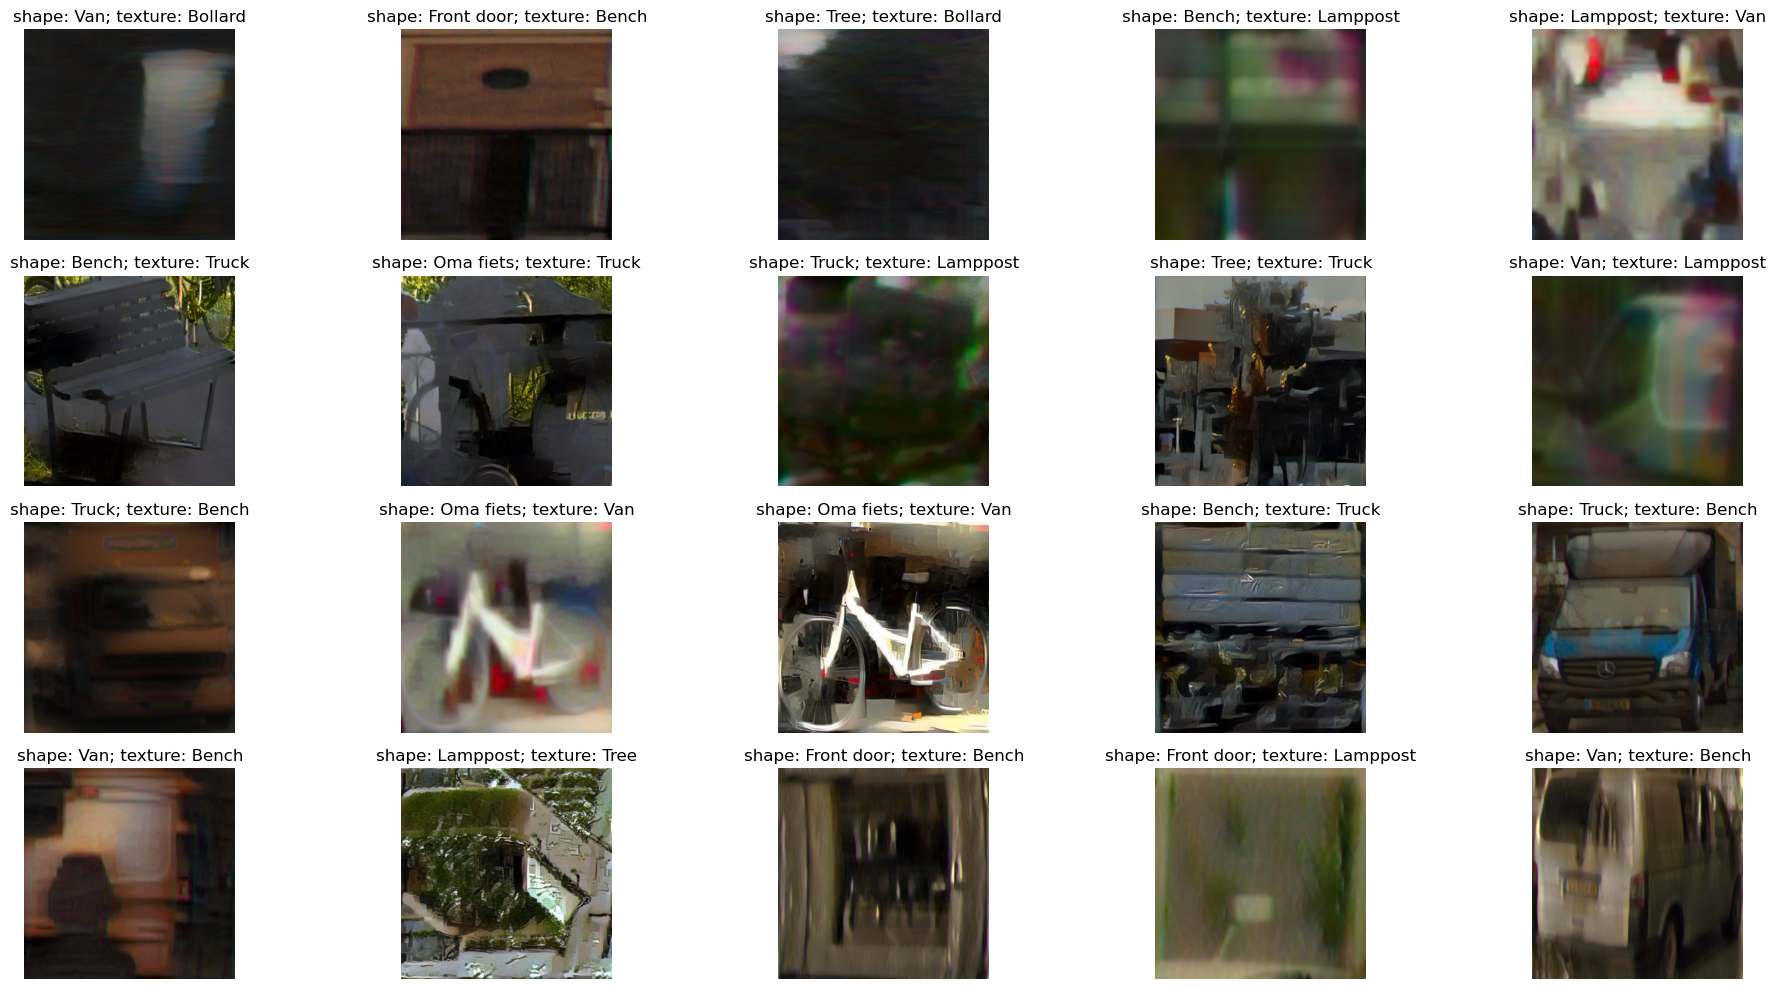

In [100]:
indices = list(range(len(images)))
np.random.shuffle(indices)
indices = indices[:20]
fig = plot_images(images=[images[i] for i in indices], titles=[titles[i] for i in indices], max_images=20, figsize=(20, 10))

# Test on model

In [11]:
# random_model = resnet50()
# random_model.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=random_model.conv1.out_channels, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
# random_model.fc = nn.Linear(
#     in_features=2048, out_features=output_channels, bias=True)

# random_model = nn.DataParallel(random_model)
# random_model = random_model.to(device=device)

In [24]:
model_names = [f'{model_type}_{image_representation}_{image_quality}' for model_type in ['resnet50', 'resnet18'] for image_representation in ['rgb', 'coc'] for image_quality in ['raw', 'jpeg', 'random']]

In [58]:
# model.eval()
# random_model.eval()

n_total = 0
n_per_class = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}
any_correct = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}
texture_correct = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}
shape_correct = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}

# random_any_correct = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}
# random_texture_correct = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}
# random_shape_correct = {model_name: {shape_class: {texture_class: 0 for texture_class in classes} for shape_class in classes} for model_name in model_names}

for shape_class in results.keys():
    for image_name in results[shape_class].keys():
        for texture_class in results[shape_class][image_name]:
            for other_image_name, morph in results[shape_class][image_name][texture_class].items():
                if morph is None:
                    continue

                for model_name in model_names:
                    model_type, image_representation, image_quality = model_name.split('_')
                    model = models[model_type][image_representation][image_quality]

                    c_morph = morph.clone()
                    if 'coc' in image_representation:
                        # print(c_morph.cpu().detach().numpy()[0,:,:,:].shape)
                        # print(c_morph.cpu().detach().numpy()[0,:,:,:].shape)
                        c_morph = transforms.ToPILImage()(c_morph[0,:,:,:])
                        # print(c_morph.size)
                        c_morph = ToOpponentChannel()(c_morph)
                        c_morph = transforms.ToTensor()(c_morph).unsqueeze(0).to(device)
                        # c_morph = transform(c_morph)

                    scores = model(c_morph)

                    _, predictions = scores.max(1)
                    # predictions
                    # print(f'Shape: {shape_class}, texture: {texture_class}, pred: {index_label_mapping[predictions.cpu().numpy()[0]]}')
                    pred_class = index_label_mapping[predictions.cpu().numpy()[0]]
                    if pred_class == shape_class:
                        any_correct[model_name][shape_class][texture_class] += 1
                        shape_correct[model_name][shape_class][texture_class] += 1
                    elif pred_class == texture_class:
                        any_correct[model_name][shape_class][texture_class] += 1
                        texture_correct[model_name][shape_class][texture_class] += 1
                    else:
                        pass

                # RANDOM
                # random_scores = random_model(morph)

                # _, random_predictions = random_scores.max(1)
                # # random_predictions
                # # print(f'Shape: {shape_class}, texture: {texture_class}, random prediction: {index_label_mapping[random_predictions.cpu().numpy()[0]]}')
                # random_pred_class = index_label_mapping[random_predictions.cpu().numpy()[0]]
                # if random_pred_class == shape_class:
                #     random_any_correct[shape_class][texture_class] += 1
                #     random_shape_correct[shape_class][texture_class] += 1
                # elif random_pred_class == texture_class:
                #     random_any_correct[shape_class][texture_class] += 1
                #     random_texture_correct[shape_class][texture_class] += 1
                # else:
                #     pass

                    n_per_class[model_name][shape_class][texture_class] += 1
                n_total += 1


In [13]:
# print(f'Random:\n{random_any_correct}/{n_total} correct\n{random_shape_correct}/{random_any_correct} shape correct\n{random_texture_correct}/{random_any_correct} texture correct\n\n')

# print(f'{any_correct}/{n_total} correct\n{shape_correct}/{any_correct} shape correct\n{texture_correct}/{any_correct} texture correct')

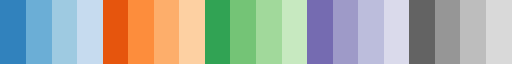

In [81]:
import matplotlib as mpl
tab20c = mpl.cm.get_cmap('tab20c')
tab20c

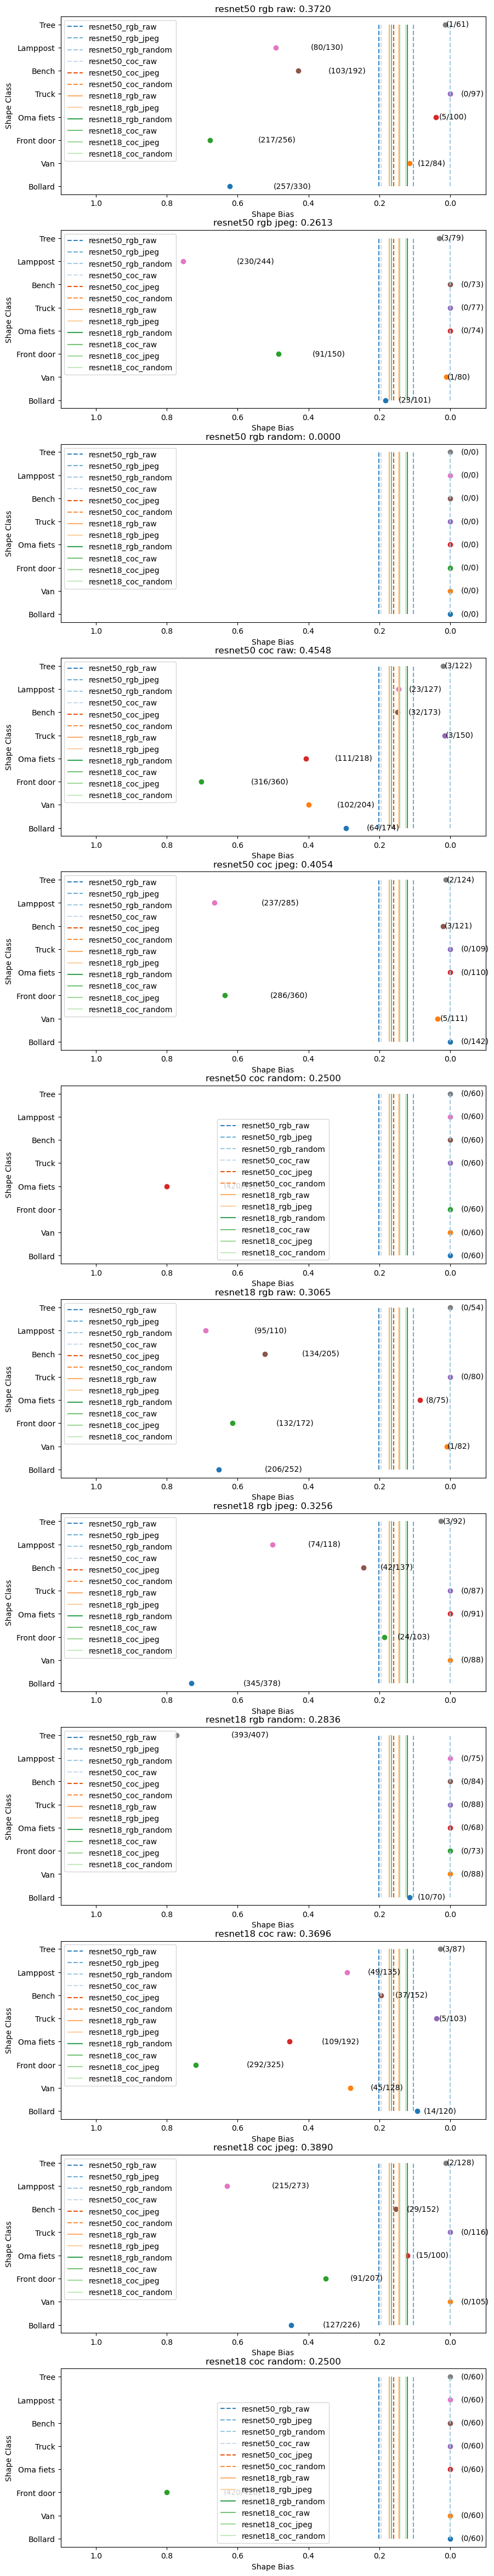

In [93]:
fig, ax = plt.subplots(len(model_names), 1, figsize=(10,5*len(model_names)))

for model_index, model_name in enumerate(model_names):
    model_type, image_representation, image_quality = model_name.split('_')

    total_shape_mean = []
    total_correct_mean = []

    for index, shape_class in enumerate(classes):
        total_shape = 0
        total_correct = 0
        for texture_class in classes:
            total_shape += shape_correct[model_name][shape_class][texture_class]
            total_correct += any_correct[model_name][shape_class][texture_class]

        total_correct_mean.append(total_correct)
        total_shape_mean.append(total_shape)

        # print(shape_class, total)
        shape_bias = total_shape/max(1, total_correct) * 0.8
        ax[model_index].scatter([shape_bias], index)

        x_text = shape_bias * 0.8 if shape_bias > 0.0 else -0.03
        ax[model_index].text(x_text, index-0.08, s=f'({total_shape}/{total_correct})')

    # Weight by general accuracy
    accuracy = sum(total_correct_mean) / n_total

    # Plot across all axes
    for all_index in range(len(model_names)):
        ax[all_index].vlines([accuracy * sum(total_shape_mean) / max(1, sum(total_correct_mean))], ymin=0, ymax=len(classes)-1, label=model_name, colors=tab20c.colors[model_index], linestyles='dashed' if model_type == 'resnet50' else 'solid')


    ax[model_index].set_xlabel('Shape Bias')
    ax[model_index].set_ylabel('Shape Class')
    ax[model_index].set_yticks(range(len(classes)))
    ax[model_index].set_yticklabels(classes)
    ax[model_index].set_xlim(-0.1,1.1)
    ax[model_index].invert_xaxis()

    ax[model_index].set_title(f"{' '.join(model_name.split('_'))}: {accuracy:.4f}")

for all_index in range(len(model_names)):
    ax[all_index].legend()

plt.show()